In [22]:
import matplotlib.pyplot as plt # plotting library
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd 
import random 
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split, Dataset
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import math
import cv2
import torch.distributions as td

In [23]:
random_seed = 111

In [24]:
seqlen = 8 

In [25]:
origin_dataset = torch.load('moving_minst_data.pt')

masks = torch.load('moving_minst_data_masks.pt')
dataset=origin_dataset*masks
origin_dataset_seq = []
dataset_seq=[]
masks_seq = []
for i in range(0,len(dataset)-(len(dataset)%seqlen),seqlen):
    origin_dataset_seq.append(origin_dataset[i:i+seqlen, :])
    dataset_seq.append(dataset[i:i+seqlen, :])
    masks_seq.append(masks[i:i+seqlen, :])
origin_dataset_seq=torch.stack(origin_dataset_seq, dim=0)
dataset_seq=torch.stack(dataset_seq, dim=0)
masks_seq=torch.stack(masks_seq, dim=0)

m=len(dataset_seq)

x_train_full,x_val_full = origin_dataset_seq[0:int(0.8*m)],origin_dataset_seq[int(0.8*m):m]
x_train_miss,x_val_miss= dataset_seq[0:int(0.8*m)],dataset_seq[int(0.8*m):m]
m_train_miss, m_val_miss = masks_seq[0:int(0.8*m)],masks_seq[int(0.8*m):m]

In [26]:
class CustomDataset(Dataset):
    def __init__(self, x, m):
        self.x = x
        self.m = m

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.m[idx]

In [27]:
batch_size=160
train_dataset = CustomDataset(x_train_miss, m_train_miss)
val_dataset = CustomDataset(x_val_miss, m_val_miss)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True)

In [28]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):  
        super(VariationalEncoder, self).__init__()
        self.latent_dims = latent_dims
        self.conv1 = nn.Conv2d(1, 16, kernel_size, stride, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size, stride, padding=1)
        self.batch2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 64, kernel_size, stride, padding=1)  
        self.conv4 = nn.Conv2d(64, 128, kernel_size, stride, padding=1)
        self.batch3 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(128, 256, kernel_size, stride, padding=1)
        self.linear1 = nn.Linear(256*2*2, 128)

        self.conv1d = nn.Conv1d(128,128, kernel_size=3,padding="same")

        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        

        self.N = td.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0
        
    def forward(self, x):
        x = x.to(device)
        x = x.view(-1,1,64,64)

        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        
        x = F.relu(self.conv3(x))
        
        x = F.relu(self.batch3(self.conv4(x)))
        x = F.relu(self.conv5(x))
        
        x = torch.flatten(x, start_dim=1)
        
        x = F.relu(self.linear1(x))
      
        x = x.view(-1,seqlen,128)
        x = x.permute(0,2,1)
        
        x = self.conv1d(x)
        x = x.permute(0,2,1)
        
        mu =  self.linear2(x)
        mu = mu.permute(0,2,1)
        sigma = torch.exp(self.linear3(x))
        sigma = sigma.permute(0,2,1)
        return td.Independent(td.Normal(
                    mu,
                    sigma),1)
        # rand_state = torch.random.get_rng_state()[0]
        # torch.random.manual_seed(rand_state+1)
        # z = mu + sigma*self.N.sample(mu.shape)
        # self.kl=-0.5 * torch.sum(1 + sigma - mu.pow(2) - sigma.exp())
        # # self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z   
    

In [29]:
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        self.latent_dims = latent_dims
        super().__init__()

        self.decoder_lin = nn.Sequential(
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            nn.Linear(128, 256*2*2),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(256, 2, 2))

        self.decoder_conv = nn.Sequential(

            nn.ConvTranspose2d(256, 128, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 32, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.ConvTranspose2d(32, 16, kernel_size, stride, padding=1, output_padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 1, kernel_size, stride, padding=1, output_padding=1),
            nn.Upsample(size=(64,64))
        )
        
    def forward(self, x):
        
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        
        x = torch.sigmoid(x)
        return x

In [30]:
class GaussianDecoder(Decoder):
    def forward(self, x):
        x = x.permute(0,2,1).view(-1,self.latent_dims)
        x = self.decoder_lin(x)
        
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = x.view(-1,seqlen,1,64,64)
        x = torch.sigmoid(x)
       
        var = torch.ones_like(x)
        
        return td.Normal(loc=x, scale=var)

In [31]:
def rbf_kernel(T, length_scale):
    xs = torch.arange(T, dtype=torch.float32)
    xs_in = xs.unsqueeze(0)
    xs_out = xs.unsqueeze(1)
    distance_matrix = torch.square(torch.sub(xs_in, xs_out))
    distance_matrix_scaled = distance_matrix / torch.square(torch.tensor(length_scale))
    kernel_matrix = torch.exp(-distance_matrix_scaled)
    return kernel_matrix


def diffusion_kernel(T, length_scale):
    assert length_scale < 0.5, "length_scale has to be smaller than 0.5 for the "\
                               "kernel matrix to be diagonally dominant"
    sigmas = torch.ones(T, T, dtype=torch.float32) * torch.tensor(length_scale)
    sigmas_tridiag = sigmas.diag(-1) + sigmas.diag() + sigmas.diag(1)
    kernel_matrix = sigmas_tridiag + torch.eye(T)*(1. - length_scale)
    return kernel_matrix


def matern_kernel(T, length_scale):
    xs = torch.arange(T, dtype=torch.float32)
    xs_in = xs.unsqueeze(0)
    xs_out = xs.unsqueeze(1)
    distance_matrix = torch.abs(torch.sub(xs_in, xs_out))
    distance_matrix_scaled = distance_matrix / torch.sqrt(torch.tensor(length_scale))
    kernel_matrix = torch.exp(-distance_matrix_scaled)
    return kernel_matrix


def cauchy_kernel(T, sigma, length_scale):
    xs = torch.arange(T, dtype=torch.float32)
    xs_in = xs.unsqueeze(0)
    xs_out = xs.unsqueeze(1)
    distance_matrix = torch.square(torch.sub(xs_in, xs_out))
 
    distance_matrix_scaled = distance_matrix / torch.square(torch.tensor(length_scale))
    kernel_matrix = torch.div(sigma, (distance_matrix_scaled + 1.))

    alpha = 0.001
    eye = torch.eye(kernel_matrix.shape[-1])
    return kernel_matrix + alpha * eye

In [32]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims,kernel="rbf",time_length = 8, sigma=1., length_scale=0.4, kernel_scales=1):
        super(VariationalAutoencoder, self).__init__()
        self.time_length = time_length
        self.kernel = kernel
        self.sigma = sigma
        self.length_scale = length_scale
        self.kernel_scales = kernel_scales
        self.latent_dims = latent_dims
   

        # Precomputed KL components for efficiency
        self.pz_scale_inv = None
        self.pz_scale_log_abs_determinant = None
        self.prior = None
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = GaussianDecoder(latent_dims)
    def forward(self, x):
        x = x.to(device)
        
        pz = self._get_prior()
        
        qz_x = self.encoder(x)
        
        kl = self.kl_divergence(qz_x,pz)
      
        z = qz_x.rsample()
        
        return self.decoder(z), kl
    
    def _get_prior(self):
        if self.prior is None:
            # Compute kernel matrices for each latent dimension
            kernel_matrices = []
            for i in range(self.kernel_scales):
                if self.kernel == "rbf":
                    kernel_matrices.append(rbf_kernel(self.time_length, self.length_scale / 2**i))
                elif self.kernel == "diffusion":
                    kernel_matrices.append(diffusion_kernel(self.time_length, self.length_scale / 2**i))
                elif self.kernel == "matern":
                    kernel_matrices.append(matern_kernel(self.time_length, self.length_scale / 2**i))
                elif self.kernel == "cauchy":
                    kernel_matrices.append(cauchy_kernel(self.time_length, self.sigma, self.length_scale / 2**i))
          
            # Combine kernel matrices for each latent dimension
            tiled_matrices = []
            total = 0
            for i in range(self.kernel_scales):
                if i == self.kernel_scales-1:
                    multiplier = self.latent_dims - total
                else:
                    multiplier = int(np.ceil(self.latent_dims / self.kernel_scales))
                    total += multiplier
                tiled_matrices.append(torch.tile(kernel_matrices[i].unsqueeze(0), [multiplier, 1, 1]))
            kernel_matrix_tiled = torch.cat(tiled_matrices)
            assert len(kernel_matrix_tiled) == self.latent_dims

            self.prior = td.MultivariateNormal(
                loc=torch.zeros(self.latent_dims, self.time_length),
                covariance_matrix=kernel_matrix_tiled)
           
            
        return self.prior
    def kl_divergence(self, a, b):
        
        def squared_frobenius_norm(x):
            """Helper to make KL calculation slightly more readable."""
            return torch.sum(torch.square(x), dim=[-2, -1])

      
        if self.pz_scale_inv is None:
            
            self.pz_scale_inv = torch.linalg.inv(b.scale_tril.to_sparse().to_dense())
            
            self.pz_scale_inv = torch.where(torch.isfinite(self.pz_scale_inv),
                                            self.pz_scale_inv, torch.zeros_like(self.pz_scale_inv))
       
        if self.pz_scale_log_abs_determinant is None:
           
            

            self.pz_scale_log_abs_determinant = torch.logdet(b.scale_tril)
       
        a_scale =  torch.linalg.cholesky(torch.diag_embed(a.stddev))
        a_shape = a_scale.shape
        
        if len(b.scale_tril.shape) == 3:
            _b_scale_inv = self.pz_scale_inv[None].repeat(a_shape[0], *[1] * (len(a_shape) - 1))
        else:
            _b_scale_inv = self.pz_scale_inv.repeat(a_shape[0], *[1] * (len(a_shape) - 1))
        _b_scale_inv = _b_scale_inv.to(device)

        b_inv_a = _b_scale_inv @ a_scale.to_sparse().to_dense().to(device)
        kl_div = (self.pz_scale_log_abs_determinant.to(device) - torch.logdet(a_scale).to(device) +
                0.5 * (-torch.tensor(self.time_length).to(device) +
                squared_frobenius_norm(b_inv_a).to(device) + squared_frobenius_norm(
                torch.linalg.solve(b.scale_tril.to(device),(b.mean.to(device) - a.mean.to(device))[..., None])).to(device)))
      
        return kl_div
      


In [33]:
### Set the random seed for reproducible results
torch.manual_seed(random_seed)

kernel_size = [3,3]
stride=[2,2]

d = 20

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cuda


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv4): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (linear1): Linear(in_features=1024, out_features=128, bias=True)
    (conv1d): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=same)
    (linear2): Linear(in_features=128, out_features=20, bias=True)
    (linear3): Linear(in_features=128, out_features=20, bias=True)
  )
  (decoder): GaussianDecoder(
    (decoder_lin): Sequential(
      (0): Li

In [34]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, mask in dataloader: 
        # Move tensor to the proper device
     
        x = x.to(device)
        mask = mask.to(device)
       
        px_z,kl = vae(x)

        temp_mask = mask.squeeze().flatten(0,1).flatten(1,2)
        mask_sum = temp_mask.sum(1)
        boolen_mask = (mask_sum == 0)
        
        temp_mask[boolen_mask] = 1
        
        temp_mask = temp_mask.reshape(mask.shape)
       
        # Evaluate loss
        nll = (-px_z.log_prob(x)*temp_mask).sum((2,3,4)).mean()
        
        kl = kl.sum((1)).mean()

        loss = nll + kl*0.1
        
        # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
      
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        # print('\t partial train loss (single batch): %f' % (loss.item()))
        nll_loss += nll.item()
        kl_loss += kl.item()

        train_loss+=loss.item()
        

    return train_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader)

In [35]:
def test_epoch(vae, device, dataloader):
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    nll_loss = 0.0
    kl_loss = 0.0
    with torch.no_grad(): # No need to track the gradients
        for x, mask in dataloader:
         
            # Move tensor to the proper device
          
            x = x.to(device)
            mask = mask.to(device)
            px_z,kl = vae(x)
        
            # Evaluate loss
            nll = (-px_z.log_prob(x)*mask).sum((2,3,4)).mean()
        
            kl = kl.sum((1)).mean()

            loss = nll + kl*0.1

            
            # loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            nll_loss += nll.item()
            kl_loss += kl.item()

          
            val_loss += loss.item()

    return val_loss / len(dataloader), nll_loss / len(dataloader), kl_loss / len(dataloader)

In [36]:
def plot_ae_outputs(encoder,decoder,n=10,random_seed = random_seed):
    fig, axs = plt.subplots(10, 2,figsize=(30,100))
    # targets = [item[0] for item in test_data]
    # t_idx = {i:np.where(targets==i)[0][0] for i in range(n)}
    i=0
    random.seed(random_seed)
   
    for index in random.sample(range(len(x_val_miss)), n):
      img = x_val_miss[index].unsqueeze(0).to(device)
      encoder.eval()
      decoder.eval()
      with torch.no_grad():
         print(img.shape)
         rec_img = decoder(encoder(img).sample()).mean
         print(rec_img.shape)
      axs[i,0].imshow(img[0][0].cpu().squeeze().numpy(), cmap='gray')
     
      axs[i,1].imshow(rec_img[0][0].cpu().squeeze().numpy(), cmap='gray')
      i=i+1

In [37]:
num_epochs = 200
train_loss_sum = []
train_nll_sum = []
train_kl_sum = []
val_loss_sum = []
val_nll_sum = []
val_kl_sum = []
for epoch in range(num_epochs):
   train_loss,train_nll_loss,train_kl_loss = train_epoch(vae,device,train_loader,optim)
   val_loss,val_nll_loss,val_kl_loss = test_epoch(vae,device,valid_loader)
   train_loss_sum.append(train_loss)
   train_nll_sum.append(train_nll_loss)
   train_kl_sum.append(train_kl_loss)
   val_loss_sum.append(val_loss)
   val_nll_sum.append(val_nll_loss)
   val_kl_sum.append(val_kl_loss)
   print('\n EPOCH {}/{} \t train loss {:.3f} \t train nll loss {:.3f} \t train kl loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,train_nll_loss,train_kl_loss))
   print('\n val loss {:.3f} \t val nll loss {:.3f} \t val kl loss {:.3f}'.format(val_loss,val_nll_loss,val_kl_loss))
   # plot_ae_outputs(vae.encoder,vae.decoder,n=10)


 EPOCH 1/200 	 train loss 2785.415 	 train nll loss 2785.348 	 train kl loss 0.670

 val loss 1232.430 	 val nll loss 1232.407 	 val kl loss 0.238

 EPOCH 2/200 	 train loss 2741.389 	 train nll loss 2741.375 	 train kl loss 0.140

 val loss 1223.331 	 val nll loss 1223.319 	 val kl loss 0.118

 EPOCH 3/200 	 train loss 2707.398 	 train nll loss 2707.390 	 train kl loss 0.080

 val loss 1205.509 	 val nll loss 1205.504 	 val kl loss 0.058

 EPOCH 4/200 	 train loss 2687.903 	 train nll loss 2687.884 	 train kl loss 0.191

 val loss 1185.167 	 val nll loss 1185.162 	 val kl loss 0.047

 EPOCH 5/200 	 train loss 2668.204 	 train nll loss 2668.097 	 train kl loss 1.071

 val loss 1168.500 	 val nll loss 1168.487 	 val kl loss 0.130

 EPOCH 6/200 	 train loss 2653.064 	 train nll loss 2652.834 	 train kl loss 2.306

 val loss 1156.036 	 val nll loss 1155.982 	 val kl loss 0.544

 EPOCH 7/200 	 train loss 2640.885 	 train nll loss 2640.504 	 train kl loss 3.803

 val loss 1149.011 	 val nl

In [38]:
# plot_ae_outputs(vae.encoder,vae.decoder,n=10,random_seed = 12)

Text(0, 0.5, 'Kl Loss')

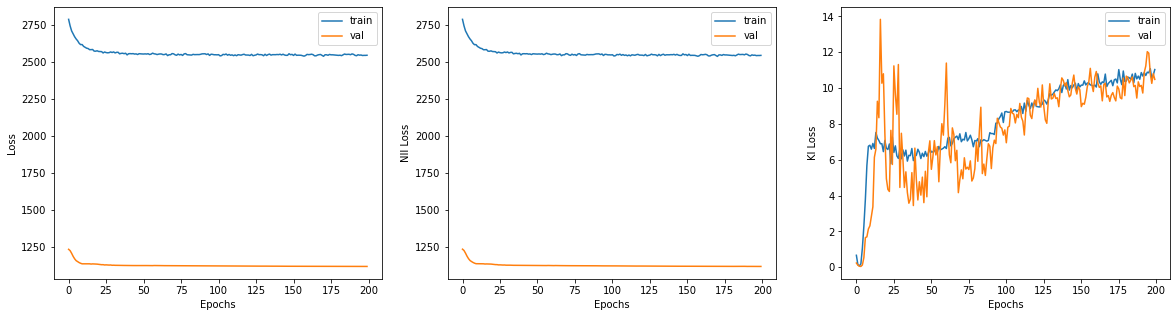

In [39]:
fig, axs = plt.subplots(1, 3,figsize=(20,5))

axs[0].plot(train_loss_sum, label="train")
axs[0].plot(val_loss_sum,label = "val")
axs[0].legend()
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].plot(train_nll_sum, label="train")
axs[1].plot(val_nll_sum,label = "val")
axs[1].legend()
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Nll Loss")
axs[2].plot(train_kl_sum, label="train")
axs[2].plot(val_kl_sum,label = "val")
axs[2].legend()
axs[2].set_xlabel("Epochs")
axs[2].set_ylabel("Kl Loss")

In [40]:
def ssim(img1, img2):
    C1 = (0.01 * 1)**2
    C2 = (0.03 * 1)**2

    # img1 = img1.astype(np.float64)
    # img2 = img2.astype(np.float64)
    kernel = cv2.getGaussianKernel(11, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv2.filter2D(img1, -1, window)[5:-5, 5:-5]  # valid
    mu2 = cv2.filter2D(img2, -1, window)[5:-5, 5:-5]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv2.filter2D(img1**2, -1, window)[5:-5, 5:-5] - mu1_sq
    sigma2_sq = cv2.filter2D(img2**2, -1, window)[5:-5, 5:-5] - mu2_sq
    sigma12 = cv2.filter2D(img1 * img2, -1, window)[5:-5, 5:-5] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):
    '''calculate SSIM
    the same outputs as MATLAB's
    img1, img2: [0, 255]
    '''
    if not img1.shape == img2.shape:
        raise ValueError('Input images must have the same dimensions.')
    if img1.ndim == 2:
        return ssim(img1, img2)
    elif img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()
        elif img1.shape[2] == 1:
            return ssim(np.squeeze(img1), np.squeeze(img2))
    else:
        raise ValueError('Wrong input image dimensions.')

In [41]:
# test_predict_loss = 0.0
# test_impu_loss = 0.0
# test_impu_part_loss = 0.0
# impuated_data_sum = 0
# test_psnr = 0
# test_ssim =0
# input_dataset = x_val_miss
# compare_dataset = x_val_full
# with torch.no_grad():

#     for i in range(len(x_val_miss)):
        
#         x = input_dataset[i]
      
#         y = compare_dataset[i]
     
#         input_image = x.unsqueeze(0)
        
#         predict_image = vae.decoder(vae.encoder(input_image).sample()).mean.cpu()
        
#         image_mask = m_val_miss[i]
#         impuated_data_sum+=(image_mask.flatten()==0).sum().item()
#         imputed_part = predict_image*(1-image_mask)
     
#         full_part = y*(1-image_mask)
     
       
#         loss_p = (abs(predict_image - y)/(predict_image.size(-1)*predict_image.size(-2))).sum()/seqlen
#         loss_ip = (abs(imputed_part - full_part)).sum()
#         mse= (((predict_image - y)**2)/(predict_image.size(-1)*predict_image.size(-2))).sum()/seqlen
        
        
#         psnr = 20*math.log10(1/math.sqrt(mse))
#         test_psnr += psnr
       
#         test_predict_loss += loss_p.item()
       
#         test_impu_part_loss += loss_ip.item()
#         ssim_p = 0
       
#         for j in range(len(predict_image.squeeze())):
#             ssim_p += ssim(predict_image.squeeze()[j].squeeze().cpu().detach().numpy(),y.squeeze()[j].squeeze().cpu().detach().numpy())
#         test_ssim += ssim_p/seqlen
       


# print(test_predict_loss / len(input_dataset))
# print(test_impu_part_loss / impuated_data_sum)
# print(test_psnr / len(input_dataset))
# print(test_ssim / len(input_dataset))

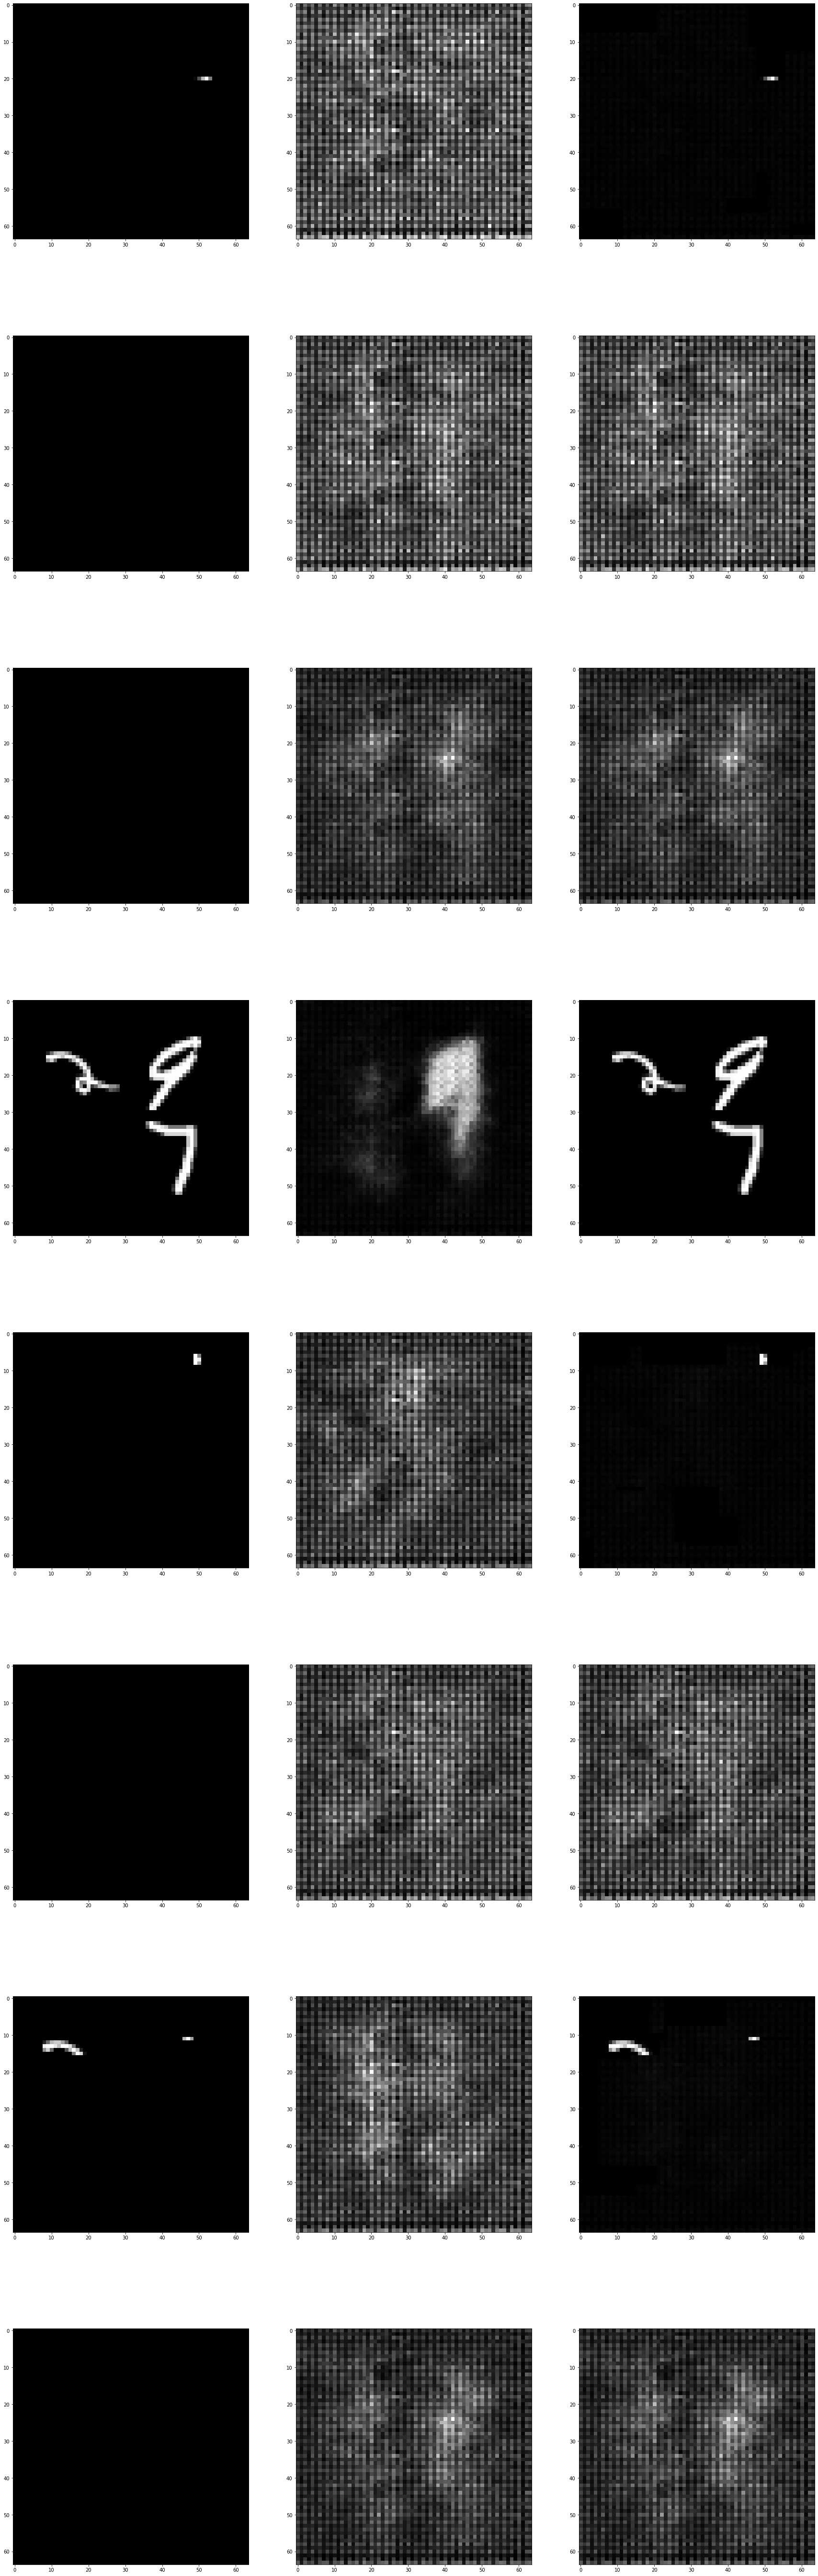

In [42]:
one = np.random.randint(len(x_val_miss))

one = 2

input = x_val_miss[one].to(device).unsqueeze(0)
mask = m_val_miss[one].to(device)

# input = torch.cat((x,mask),dim=1).unsqueeze(0)
y_origin = x_val_full[one].to(device)

fig, axs = plt.subplots(8, 3,figsize=(30,100))

   
imgs = input.to(device)
    
vae.encoder.eval()
vae.decoder.eval()
with torch.no_grad():
    rec_img  = vae.decoder(vae.encoder(imgs).sample()).mean
imputated_result = rec_img*(1-mask)+imgs*mask
for index in range(seqlen):
    
    axs[index,0].imshow(imgs.cpu().squeeze()[index].numpy(), cmap='gray')

    axs[index,1].imshow(rec_img.cpu().squeeze()[index].numpy(), cmap='gray')

    axs[index,2].imshow(imputated_result.cpu().squeeze()[index].numpy(), cmap='gray')